In [ ]:
# PATH_ = '/content/drive/MyDrive/ML/Data_Driven_Marketing/Data-Driven-Marketing-Project2/Data/ghepcode.csv'
# m = pd.r

# INFO

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
PATH = '/content/drive/MyDrive/ML/Data_Driven_Marketing/Data-Driven-Marketing-Project2/Data/bank-additional-full.csv'
data = pd.read_csv(PATH, delimiter=';')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
data['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [3]:
####remove duplicated rows or columns
data = data.drop_duplicates(keep='first')
data = data.loc[:,~data.columns.duplicated()]
data.shape

(41176, 21)

In [ ]:
cat_feats = [col for col in data.columns\
             if data[col].dtypes=='object']
num_feats = [col for col in data.columns\
            if data[col].dtypes!='object']
print('number of categorical features:',len(cat_feats))
print('number of numeric features:',len(num_feats))

number of categorical features: 11
number of numeric features: 10


In [ ]:
Cat_List = {}
for cat in cat_feats:
    Cat_List[cat] = data[cat].nunique()

Cat_List 

{'contact': 2,
 'day_of_week': 5,
 'default': 3,
 'education': 8,
 'housing': 3,
 'job': 12,
 'loan': 3,
 'marital': 4,
 'month': 10,
 'poutcome': 3,
 'y': 2}

In [ ]:
data = data.replace(to_replace ="unknown",value = np.nan)
null_df = data.isnull().sum().reset_index()
null_df.columns = ['Features','Nbr_Null']
null_df['Pct_Null'] = round(100*null_df['Nbr_Null']/data.shape[0],2)
null_df

,Features,Nbr_Null,Pct_Null
0,age,0,0.00
1,job,330,0.80
2,marital,80,0.19
3,education,1730,4.20
4,default,8596,20.88
5,housing,990,2.40
6,loan,990,2.40
7,contact,0,0.00
8,month,0,0.00
9,day_of_week,0,0.00


In [ ]:
dat = data.copy()

# HELPFUL FUNCTIONS

In [34]:
def map_age_group(age):
  if age < 35:
    return 'young'
  elif (age >= 35) & (age < 50):
    return 'middle_age'
  else:
    return 'old'

In [35]:
def apply_marital_age(y, x):
  if y == '':
    if x < 33:
      return 'single'
    else:
      return 'married'
  else:
    return y

def one_hot(df, cols):
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [36]:
def ghepCode(arg):
    s = ""
    for i in arg.values:
      s += str(i)
    return s

In [37]:
def cal_tbc_code(data, col_code, target_col):
  """
  data : tập data đưa vào
  col_code : thường là ghepcode : cột code đã được ghép
  cal_col : cột đang cần fill
  """
  tbc = {}
  unique_code = data[col_code].value_counts().keys()
  col = target_col + '_onehot'
  data[col] = data[target_col].replace({'no': 0, 'yes' : 1})
  for value in unique_code:
    if value not in tbc:
      tab = data[data[col_code]== value][col].mean()
      tbc[value] = tab
  return tbc


In [38]:
def generate_code_cols_func(df, one_hot_col):
  distinct_value = []
  for col in one_hot_col:
    unique_value = df[col].value_counts().keys()
    # print(unique_value)
    for uni in unique_value:
      distinct_value.append( col + '_' + str(uni) )

  return distinct_value

In [39]:
def cal_distance(num, lst):
  distance = []
  for n in lst:
    d = np.abs(int(num) - int(n))
    distance.append(d)
  min_index = np.argmin(distance)
  return lst[min_index]


In [42]:
def fill_value_by_code(df,col_code,  onehot_cols, target_col):
  """
  df : data cho vao
  col_code : tên cột ghép code : thường là ghepcode
  target_code : tên cột cần fill
  """

  # generate code cols
  generate_code_cols = generate_code_cols_func(df, onehot_cols)
  # onehot
  data_temp = one_hot(df, onehot_cols)
  temp = data_temp[generate_code_cols]
  # ghep code
  data_temp[col_code] = temp.apply(lambda row: ghepCode(row), axis = 1) 
  data_not_null = data_temp[~data_temp[target_col].isnull()]
  data_null = data_temp[data_temp[target_col].isnull()]
  #fill cac gia tri NaN thanh filll
  data_temp[target_col].fillna('filll', inplace = True)
  #tinh tbc cua cac code
  tbc = cal_tbc_code(data_not_null, col_code, target_col)
  # print('tbc ', tbc)
  # fill gia tri
  for i in range(len(data_temp[target_col])):
    if data_temp[target_col].iloc[i] == 'filll':
      try:
        value = data_temp[col_code].iloc[i]
        if value not in list(tbc.keys()):
          value_ = cal_distance(value, list(tbc.values()))
        else:
          value_ = value
        prob = tbc[value_]
        if prob > 0.5:
          data_temp[target_col].iloc[i] = 'yes'
        else:
          data_temp[target_col].iloc[i] = 'no'
      except:
        pass
  return data_temp


In [68]:
def apply_rank(x):
  if x == 0:
    return 'illiterate'
  elif x == 1:
    return 'basic.6y'
  elif x == 2:
    return 'high.school'
  else:
    return 'university.degree'

def fill_education(df):
  #fill nan bang 2
  df['education'].fillna(2, inplace = True)
  for i in range(len(df['education'])):
    if df['education'].iloc[i] == 2:
      df['education'].iloc[i] = apply_rank(df['job_rank'].iloc[i])
    else:
      pass
  return df

# AGE

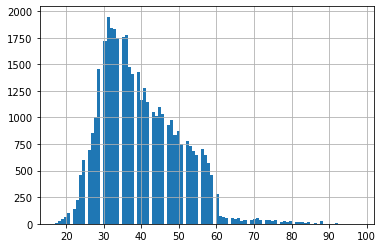

In [ ]:
data['age'].hist(bins = 100)

In [ ]:
data['age_group'] = data['age'].apply(lambda x : map_age_group(x))
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,middle_age
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,middle_age
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old


In [ ]:
dat['age_group'] = dat['age'].apply(lambda x : map_age_group(x))
dat.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,middle_age
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,middle_age
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old


In [ ]:
data['age_group'].value_counts()

middle_age    18372
young         14751
old            8053
Name: age_group, dtype: int64

# CONTACT

In [ ]:
data['contact'].value_counts()

cellular     26135
telephone    15041
Name: contact, dtype: int64

# POUTCOME

In [ ]:
data['poutcome'].value_counts()

nonexistent    35551
failure         4252
success         1373
Name: poutcome, dtype: int64

# JOB

In [ ]:
data['job'].fillna(data['job'].mode()[0], inplace=True)

In [ ]:
data['job'].value_counts()

admin.           10749
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
Name: job, dtype: int64

In [ ]:
job_rank = {
    'unemployed': 0, 'student' : 1, 'retired' : 1, 'housemaid': 1,
    'blue-collar' : 2, 'admin.' : 2, 'services' : 2, 'technician' : 2,
    'management': 3, 'self-employed' : 3, 'entrepreneur' : 3
}

In [ ]:
data['job_rank'] = data['job'].replace(job_rank)
data['job_rank'].value_counts()

2    30708
3     5801
1     3653
0     1014
Name: job_rank, dtype: int64

# MARITAL
fillna = age

In [ ]:
data['marital'].value_counts()

married     24921
single      11564
divorced     4611
Name: marital, dtype: int64

In [ ]:
data_cop_mari = data.copy()

In [ ]:
data_cop_mari['marital'].fillna('', inplace = True)
data_cop_mari['marital'].isnull().sum()

0

In [ ]:
data_cop_mari['marital'].value_counts()

married     24921
single      11564
divorced     4611
               80
Name: marital, dtype: int64

In [ ]:
for i in range(len(data_cop_mari['marital'])):
  value = apply_marital_age(data_cop_mari['marital'].iloc[i], data_cop_mari['age'].iloc[i])
  data_cop_mari['marital'].iloc[i] = value

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
data_cop_mari['marital'].value_counts()

married     24977
single      11588
divorced     4611
Name: marital, dtype: int64

In [ ]:
data2 = data_cop_mari.copy()

#HOUSING
fillna = code

In [ ]:
data2.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'age_group',
       'job_rank'],
      dtype='object')

In [ ]:
one_hot_col_housing = ['job_rank', 'marital','age_group', ]
data_temp = fill_value_by_code(data2, 'ghepcode_housing',
                               onehot_cols= one_hot_col_housing,
                               target_col = 'housing')
data_temp.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group,job_rank,job_rank_0,job_rank_1,job_rank_2,job_rank_3,marital_divorced,marital_married,marital_single,age_group_middle_age,age_group_old,age_group_young,ghepcode_housing
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old,1,0,1,0,0,0,1,0,0,1,0,0010100001
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old,2,0,0,1,0,0,1,0,0,1,0,1000100001
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,middle_age,2,0,0,1,0,0,1,0,1,0,0,1000100100
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,middle_age,2,0,0,1,0,0,1,0,1,0,0,1000100100
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old,2,0,0,1,0,0,1,0,0,1,0,1000100001


In [ ]:
data_temp['housing'].value_counts()

yes    22542
no     18634
Name: housing, dtype: int64

In [ ]:
data_temp['housing'].isnull().sum()

0

In [ ]:
data['housing'].value_counts()

yes    21571
no     18615
Name: housing, dtype: int64

In [ ]:
col_drop = generate_code_cols_func(data_temp, one_hot_col_housing)
data_temp = data_temp.drop(columns = col_drop)

In [ ]:
data_temp.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group,job_rank,ghepcode_housing
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old,1,0010100001
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old,2,1000100001
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,middle_age,2,1000100100
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,middle_age,2,1000100100
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old,2,1000100001


In [ ]:
data3 = data_temp.copy()

# LOAN

In [ ]:
one_hot_col_loan = ['job_rank', 'housing', 'age_group', 'marital']
data_temp = fill_value_by_code(data3, 'ghepcode_loan',
                               onehot_cols= one_hot_col_loan,
                               target_col = 'loan')
data_temp.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group,job_rank,ghepcode_housing,job_rank_0,job_rank_1,job_rank_2,job_rank_3,housing_no,housing_yes,age_group_middle_age,age_group_old,age_group_young,marital_divorced,marital_married,marital_single,ghepcode_loan
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old,1,0010100001,0,1,0,0,1,0,0,1,0,0,1,0,001001001100
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old,2,1000100001,0,0,1,0,1,0,0,1,0,0,1,0,100001001100
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,middle_age,2,1000100100,0,0,1,0,0,1,1,0,0,0,1,0,100010100100
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,middle_age,2,1000100100,0,0,1,0,1,0,1,0,0,0,1,0,100001100100
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old,2,1000100001,0,0,1,0,1,0,0,1,0,0,1,0,100001001100


In [ ]:
data_temp['loan'].value_counts()

no     34928
yes     6248
Name: loan, dtype: int64

In [ ]:
data_temp['loan'].isnull().sum()

0

In [ ]:
col_drop = generate_code_cols_func(data_temp, one_hot_col_loan)
data_temp = data_temp.drop(columns = col_drop)

In [ ]:
data_temp.isnull().sum()

age                    0
job                    0
marital                0
education           1730
default             8596
housing                0
loan                   0
contact                0
month                  0
day_of_week            0
duration               0
campaign               0
pdays                  0
previous               0
poutcome               0
emp.var.rate           0
cons.price.idx         0
cons.conf.idx          0
euribor3m              0
nr.employed            0
y                      0
age_group              0
job_rank               0
ghepcode_housing       0
ghepcode_loan          0
dtype: int64

In [ ]:
data5 = data_temp.copy()

# DEFAULT

In [ ]:
data5.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group,job_rank,ghepcode_housing,ghepcode_loan
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old,1,0010100001,001001001100
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old,2,1000100001,100001001100
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,middle_age,2,1000100100,100010100100
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,middle_age,2,1000100100,100001100100
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old,2,1000100001,100001001100


In [ ]:
one_hot_col_default = ['job_rank', 'housing', 'loan', 'age_group', 'marital']
data_temp = fill_value_by_code(data5, 'ghepcode_default',
                               onehot_cols= one_hot_col_default,
                               target_col = 'default')
data_temp.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group,job_rank,ghepcode_housing,ghepcode_loan,job_rank_0,job_rank_1,job_rank_2,job_rank_3,housing_no,housing_yes,loan_no,loan_yes,age_group_middle_age,age_group_old,age_group_young,marital_divorced,marital_married,marital_single,ghepcode_default
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old,1,0010100001,001001001100,0,1,0,0,1,0,1,0,0,1,0,0,1,0,00100110001100
1,57,services,married,high.school,no,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old,2,1000100001,100001001100,0,0,1,0,1,0,1,0,0,1,0,0,1,0,10000110001100
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,middle_age,2,1000100100,100010100100,0,0,1,0,0,1,1,0,1,0,0,0,1,0,10001010100100
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,middle_age,2,1000100100,100001100100,0,0,1,0,1,0,1,0,1,0,0,0,1,0,10000110100100
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old,2,1000100001,100001001100,0,0,1,0,1,0,0,1,0,1,0,0,1,0,10000101001100


In [ ]:
data_temp['default'].value_counts()

no     41173
yes        3
Name: default, dtype: int64

In [ ]:
one_hot_col_default = ['job_rank', 'housing', 'loan', 'age_group', 'marital']
col_drop = generate_code_cols_func(data_temp, one_hot_col_default)
data_temp = data_temp.drop(columns = col_drop)
data_temp.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group,job_rank,ghepcode_housing,ghepcode_loan,ghepcode_default
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old,1,0010100001,001001001100,00100110001100
1,57,services,married,high.school,no,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old,2,1000100001,100001001100,10000110001100
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,middle_age,2,1000100100,100010100100,10001010100100
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,middle_age,2,1000100100,100001100100,10000110100100
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old,2,1000100001,100001001100,10000101001100


In [ ]:
data6 = data_temp.drop(columns = ['ghepcode_default', 'ghepcode_housing', 'ghepcode_loan'])
data6.isnull().sum()

age                  0
job                  0
marital              0
education         1730
default              0
housing              0
loan                 0
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
age_group            0
job_rank             0
dtype: int64

In [ ]:
# data6.to_csv('/content/drive/MyDrive/ML/Data_Driven_Marketing/Data-Driven-Marketing-Project2/Data/ghepcode.csv')

In [ ]:
data6.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group,job_rank
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old,1
1,57,services,married,high.school,no,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old,2
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,middle_age,2
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,middle_age,2
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old,2


# MONTH , DAY

In [69]:
PATH_NEW = '/content/drive/MyDrive/ML/Data_Driven_Marketing/Data-Driven-Marketing-Project2/Data/ghepcode.csv'
dat = pd.read_csv(PATH_NEW)
dat = dat.drop(columns = ['Unnamed: 0'])

In [70]:
dat['month_name'] = dat['month'].replace({'may': 5, 'jul': 7, 'aug': 8, 'jun': 6, 'nov': 11,
                                          'apr': 4, 'oct': 10, 'sep': 9, 'mar': 3, 'dec': 12})
dat['day_name'] = dat['day_of_week'].replace({'thu': 5, 'mon': 2, 'wed': 4, 'tue': 3, 'fri':6})
dat.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group,job_rank,month_name,day_name
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old,1,5,2
1,57,services,married,high.school,no,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old,2,5,2
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,middle_age,2,5,2
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,middle_age,2,5,2
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old,2,5,2


# EDUCATION

In [71]:
dat['education'].value_counts()

university.degree      12164
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
illiterate                18
Name: education, dtype: int64

In [72]:
data = fill_education(dat)
data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group,job_rank,month_name,day_name
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old,1,5,2
1,57,services,married,high.school,no,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old,2,5,2
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,middle_age,2,5,2
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,middle_age,2,5,2
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,old,2,5,2


In [73]:
data['education'].value_counts()

university.degree      12373
high.school            10708
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2597
illiterate                37
Name: education, dtype: int64

In [74]:
data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
age_group         0
job_rank          0
month_name        0
day_name          0
dtype: int64

In [75]:
# data.to_csv('/content/drive/MyDrive/ML/Data_Driven_Marketing/Data-Driven-Marketing-Project2/Data/fillna.csv')